# HDF5 example

We are going to retrieve some satellite data from EUMETSAT, specifically from the Advanced Microwave Sounding Unit (AMSU) on board of the MetOp satellite - this is a sensor, which is used to measure atmospheric temperatures.

To obtain data from the [EUMETSAT data store](https://data.eumetsat.int/), you must first register. Once you are logged in, you should also obtain your API key so that you can make use of the API or the custom EUMETSAT data tool. 

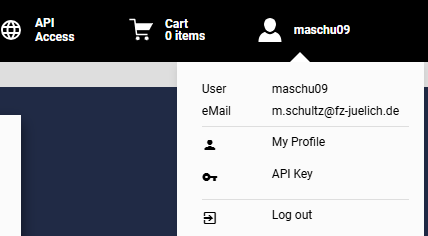

Note down all three entries: consumer key, consumer secret, and API key.

On the [AMSU details](https://data.eumetsat.int/product/EO:EUM:DAT:METOP:AMSUL1?query=&s=simple) page, you will find a product guide and format description.

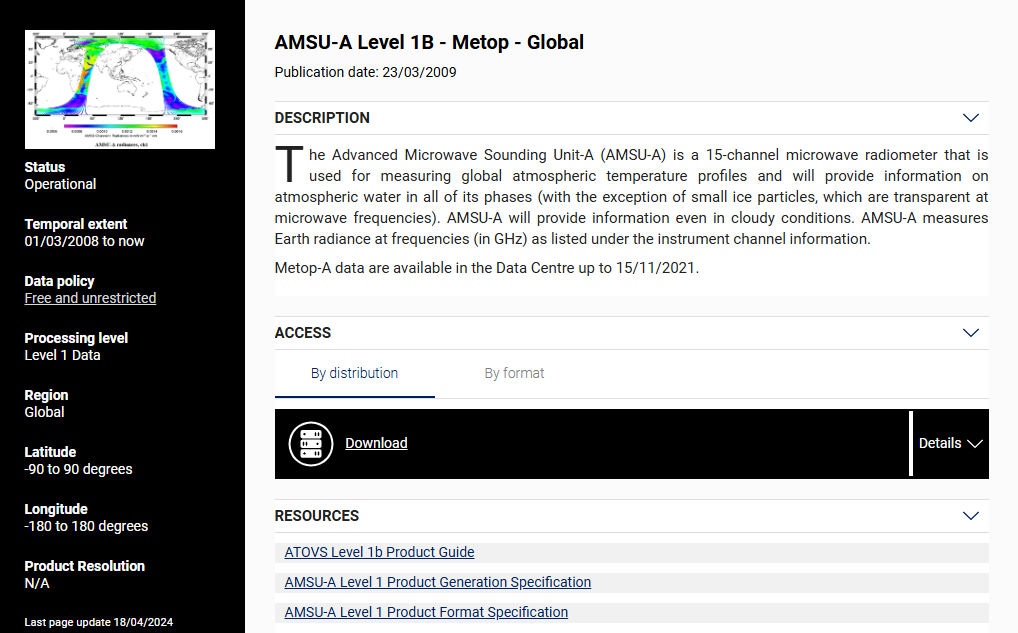

From the product guide:

## 4.1 
The ATOVS instrument suite_ 
The ATOVS (Advanced TIROS (Television and Infrared Observational Satellite) Operational 
Vertical Sounder) is a sounding instrument package first flown on the NOAA-KLM (-15, -16, -17) 
satellite series. It is composed of the Advanced Microwave Sounding Units A and B (AMSU-A, 
AMSU-B) and is complemented by the High Resolution InfraRed Sounder (HI_

_[...]_

_The AMSU-A is a fifteen-channel microwave radiometer that is used for measuring global 
atmospheric temperature profiles and providing information on atmospheric water in all of its forms. 
AMSU-A measures in 15 spectral bands, summarised in the table below, where the temperature 
sounding mainly exploits the oxygen band at 50 G_H[this is channel 3]

The viewing geometry and scan characteristics are described as follows:

_AMSU-A is an across-track scanning system with a scan range of ±48.33° with respect to the nadir 
direction. The instantaneous field of view (IFOV) of each channel is approximately 57.6 milliradians 
(3.3°) leading to a circular instantaneous field of view size close to 47.63 km at nadir and a swath 
width of ±1026.31 km (sampling time of 200.0 ms) for a nominal altitude of 833 km. The sampling 
angular interval is close to 58.18 milliradians (3.3333°). The distance between two consecutive scans 
is approximately equal to 52.69 km. 
There are 30 Earth views, two views of the internal warm target, and two views of cold space per scan 
line for each channel. Each scan takes 8.0 seconds to co_

Table 4.2 in the [document](https://user.eumetsat.int/s3/eup-strapi-media/pdf_atovsl1b_pg_8bbaa8ba48.pdf) has more details.m
We are interested in the Level 1b product. This is geolocated and calibrated and has undergone quality control.

Here is the information, how the data can be accessed (free and unrestricted):

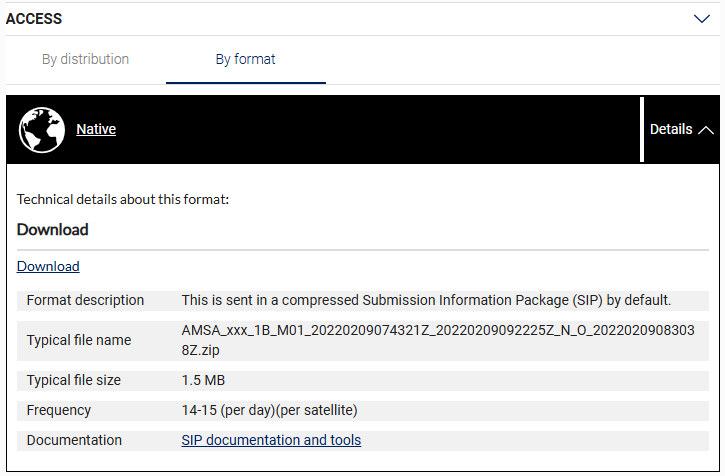

I manually selected AMSU 1B data from Metop C for May 1st, 2024 to May 3rd, 2024 (inclusive). This produces a list of 44 datasets, each of ~1.5 MBytes in size. Add to shopping cart and download...

Clicking on "download cart" gives me an XML file. This contains urls such as https://api.eumetsat.int/data/download/1.0.0/collections/EO%3AEUM%3ADAT%3AMETOP%3AAMSUL1/products/AMSA_xxx_1B_M03_20240430221919Z_20240501000119Z_N_O_20240430235645Z and suitable file names.

I guess, I will now look at the [Data store user guide](https://user.eumetsat.int/resources/user-guides/introductory-data-store-user-guide) to find out how to retriThis was semi-helpful: much too complicated for my taste.

Nevertheless, here is a hack me Python code to par that is returned from the shopping cart when you click on "download".lete.
z. S/3). 

In [ ]:
import os
import sys
import requests
import xml.etree.ElementTree as ET

In [ ]:
# Download a bunch of data files from EUMETSAT's data store
# The file names and URLs are described in an XML file
# The XML file has been downloaded from the EUMETSAT data store
# To retrieve the data, the user must provide her/his API key: ask for it.
# Skip the download if the files that are listed in the XML file are already present and readable in the current directory.
# If only some files are missing, download only those.

os.chdir("/data/mschul98/esdp1/eumetsat")

cartfile = "cart-maschu09.xml"

# parse the cartfile and return a dict with filenames and urls
def parse_cart(cartfile):
    result = {}
    tree = ET.parse(cartfile)
    root = tree.getroot()
    for child in root:
        filename = child.attrib["name"]
        url = child[0].text
        result[filename] = url
    return result

filedict = parse_cart(cartfile)


In [ ]:
# check if all files were downloaded already and load missing files
apikey = ""   # only used if a file needs to be downloaded
for filename, url in filedict.items():
    if os.path.isfile(filename) and os.access(filename, os.R_OK):
        print(f"File {filename} already present.")   
    else:
        # download the file
        print(f"Downloading {filename}...")
        if len(apikey) != 36:
            print("Please provide your EUMETSAT API key (36 characters expected):")
            apikey = input()
        response = requests.get(url, stream=True, headers={"Authorization": f"Bearer {apikey}"})
        with open(filename, "wb") as f:
            f.write(response.content)
        print(f"File {filename} downloaded")


OK. So far, so good. __BUT__ the zip files that are retrieved in this way contain so-called _nat_ files in a native satellite data format. A tiny bit of research revealed that the details of handling such data may even depend on the instrument and sensor. Not very user-friendly... 

I would be happy if someone with more knowledge could explain this to me!

If someone has time, you can check out the repository https://gitlab.eumetsat.int/eumetlab/data-services/eumdac_data_store which provides Jupyter notebooks for working with EUMETSAT data.

## New attempt: this time with HDF5 data

EUMETSAT offers a "Customizer", which also provides an option to reformat shopping cart elements in, for example HDF5 (other options are NetCDF or GRIB, or GIS formats). Disadvantage of the customizer is that you can only process max. 3 elements at a time. So, I did this for the first three files. To facilitate your life, I uploaded these 3 files to sciebo. You can access them here: https://fz-juelich.sciebo.de/s/A6wUfYMJBn1EpvD. 

The hdf5.ipynb notebook will start from here.